# Roteiro para Treinamento e Execução de Modelos com YOLOv8

## Introdução
Neste roteiro, vamos aprender a utilizar o YOLOv8, um modelo avançado para detecção de objetos. O YOLO (You Only Look Once) é uma abordagem popular devido à sua eficiência e precisão. Vamos passar pelos passos de instalação, carregamento de dados, treinamento do modelo, e finalmente, como utilizá-lo para fazer previsões em imagens e vídeos.


## Parte 1: Instalação das Bibliotecas Necessárias
Vamos começar instalando a biblioteca Ultralitycs, que contém a implementação do YOLOv8.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 33.2 MB/s eta 0:00:00


## Parte 2: Importação das Bibliotecas

Em seguida, importamos as bibliotecas que serão utilizadas em nosso projeto, incluindo cv2 para manipulação de imagens e vídeos, numpy para operações numéricas, e torch para operações com PyTorch.

In [ ]:
import os
import shutil
import cv2
import pandas as pd
import numpy as np
from IPython.display import HTML
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
from ultralytics import YOLO
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Parte 3: Download do Dataset

Você pode baixar o dataset e importar de diversas maneiras diferentes. Como recomendação, utilize o Kaggle e o Kagglehub, que ao utilizar ambientes como o Google Colab, você pode baixar e importar o diretório sem problemas diretamente pelo código. Como exemplo, estarei utilizando um dataset de detecção de veículos.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("alkanerturan/vehicledetection")
print("Path to dataset files:", path)

!ls {path}
os.environ['WANDB_DISABLED'] = 'true' # CHECAR A OBSERVAÇÃO

100%|██████████| 62.8M/62.8M [00:03<00:00, 16.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3
TestVideo  VehiclesDetectionDataset


**OBS**: Ao utilizar o YoloV8, o Wandb vem ligado por padrão. O Wandb serve para analisar o modelo e gerar gráficos, porém, precisa criar uma conta para ser utilizado, portanto, estará desabilitado para este guia.

## Parte 4: Definição de Caminhos

Aqui, definimos os caminhos para os conjuntos de dados de treinamento, validação e teste, além do arquivo YAML necessário para o treinamento.

In [ ]:
train = "/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/train"
validation = "/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/valid"
test = "/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/test"
video = "/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/TestVideo/TrafficPolice.mp4"
yaml = "/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/dataset.yaml"

Esse será o diretório padrão ao utilizar o Kagglehub num ambiente de execução do Google Colab, pode variar caso você rode localmente ou em outro ambiente.

## Parte 5: Carregamento e Preparação das Imagens

Vamos definir funções para carregar e preparar as imagens para o treinamento, incluindo redimensionamento e normalização.

In [ ]:
def load_and_prepare_image(file_path, dimensions=(640, 640)):
    img = cv2.imread(file_path)
    img_resized = cv2.resize(img, dimensions)
    img_normalized = img_resized.astype('float32') / 255.0
    return img_normalized

def apply_augmentation(image):
    return cv2.flip(image, flipCode=1)

## Parte 6: Criação do Conjunto de Dados

Nesta seção, definimos uma função para criar um conjunto de dados a partir das imagens e anotações. Também implementamos um limite opcional para o número de imagens a serem usadas.

In [ ]:
def create_dataset(directory, max_images=None):
    images_dir = os.path.join(directory, 'images')
    labels_dir = os.path.join(directory, 'labels')
    dataset = []

    for filename in os.listdir(images_dir):
        img_filepath = os.path.join(images_dir, filename)
        label_filepath = os.path.join(labels_dir, filename.replace('.jpg', '.txt'))

        original_image = load_and_prepare_image(img_filepath)
        transformed_image = apply_augmentation(original_image)

        with open(label_filepath, 'r') as label_file:
            label_content = label_file.read().strip()

        dataset.append((original_image, label_content))
        dataset.append((transformed_image, label_content))

        if max_images and len(dataset) >= max_images:
            break

    return dataset

# Definindo tamanhos de amostragem para o google colab conseguir executar
train_sample_size = 650
validation_sample_size = 250

training_data = create_dataset(train, max_images=train_sample_size)
validation_data = create_dataset(validation, max_images=validation_sample_size)

**OBS**: O train_sample_size e o validation_sample_size foram limitados para o ambiente gratuito do Google Colab conseguir executar, pois o dataset em seu tamanho original causava erro durante o treinamento por conta da RAM.

## Parte 7: Limpeza de Cache

Para garantir que não haja problemas com a memória da GPU, vamos limpar o cache.

In [ ]:
torch.cuda.empty_cache()

## Parte 8: Treinamento do Modelo

Aqui, utilizamos o YOLOv8 para treinar nosso modelo com os dados preparados.

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data=yaml, epochs=30, imgsz=640, batch=8, name='yolov8-vehicledetection')

100%|██████████| 6.25M/6.25M [00:00<00:00, 281MB/s]


Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/dataset.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8-vehicledetection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

100%|██████████| 755k/755k [00:00<00:00, 65.2MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 384MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:00<00:00, 1683.27it/s]

train: New cache created: /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 1026.49it/s]

val: New cache created: /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/valid/labels.cache


Plotting labels to runs/detect/yolov8-vehicledetection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8-vehicledetection
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.19G      1.108      2.739      1.422         19        640: 100%|██████████| 110/110 [00:26<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.08it/s]

                   all        250        454      0.349      0.346      0.313      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.18G      1.191      2.324      1.448         26        640: 100%|██████████| 110/110 [00:22<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.59it/s]

                   all        250        454      0.359      0.406      0.338      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.19G      1.218      2.258        1.5         24        640: 100%|██████████| 110/110 [00:20<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.67it/s]

                   all        250        454      0.244      0.415      0.275      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.19G       1.26      2.185      1.504         26        640: 100%|██████████| 110/110 [00:22<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.51it/s]

                   all        250        454      0.408      0.386      0.321      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.19G      1.231      2.098      1.491         19        640: 100%|██████████| 110/110 [00:20<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.93it/s]

                   all        250        454      0.416      0.404       0.37      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.19G      1.216       2.03      1.476         26        640: 100%|██████████| 110/110 [00:20<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        250        454      0.384      0.429      0.373      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.19G      1.175      1.906      1.458         28        640: 100%|██████████| 110/110 [00:20<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.74it/s]

                   all        250        454      0.326       0.48       0.37      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.19G      1.151      1.857      1.449         27        640: 100%|██████████| 110/110 [00:19<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.25it/s]


                   all        250        454      0.451      0.506       0.45      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.19G      1.112      1.722      1.415         24        640: 100%|██████████| 110/110 [00:21<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]

                   all        250        454      0.536      0.458      0.449      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.18G      1.122      1.699      1.414         13        640: 100%|██████████| 110/110 [00:19<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.13it/s]

                   all        250        454       0.62      0.479      0.545      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.18G       1.08      1.626      1.383         26        640: 100%|██████████| 110/110 [00:20<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

                   all        250        454      0.597      0.459      0.492      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.18G      1.073      1.565      1.377         16        640: 100%|██████████| 110/110 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]

                   all        250        454      0.611      0.471      0.482      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       1.2G       1.04      1.488      1.351         26        640: 100%|██████████| 110/110 [00:20<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


                   all        250        454      0.546       0.51      0.528      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.18G      1.014      1.442      1.343         18        640: 100%|██████████| 110/110 [00:21<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.10it/s]

                   all        250        454      0.548        0.5      0.546      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.19G      1.028      1.385      1.334         29        640: 100%|██████████| 110/110 [00:20<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.22it/s]

                   all        250        454      0.492      0.556      0.537      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.19G     0.9724       1.33      1.313         28        640: 100%|██████████| 110/110 [00:22<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        250        454      0.604      0.483      0.506      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.19G     0.9513      1.278      1.301         22        640: 100%|██████████| 110/110 [00:20<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.18it/s]

                   all        250        454       0.52      0.552      0.518      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.18G     0.9332      1.243      1.278         26        640: 100%|██████████| 110/110 [00:20<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


                   all        250        454       0.48      0.602      0.523      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.18G     0.9246       1.19       1.27         35        640: 100%|██████████| 110/110 [00:20<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.89it/s]

                   all        250        454      0.619      0.491      0.525      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.18G     0.8999      1.149      1.245         24        640: 100%|██████████| 110/110 [00:19<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.14it/s]

                   all        250        454      0.555      0.569      0.556      0.399


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.18G     0.8488      1.072      1.222          9        640: 100%|██████████| 110/110 [00:22<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.14it/s]

                   all        250        454      0.636      0.557      0.582      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.18G      0.789      1.002      1.191          7        640: 100%|██████████| 110/110 [00:22<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.29it/s]

                   all        250        454      0.612      0.581      0.569      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.18G     0.7865     0.9145       1.19          7        640: 100%|██████████| 110/110 [00:19<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.22it/s]

                   all        250        454      0.608      0.539      0.557      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.18G     0.7653     0.8859       1.17          6        640: 100%|██████████| 110/110 [00:21<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        250        454      0.652      0.527      0.564      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.18G     0.7565     0.8276      1.158          6        640: 100%|██████████| 110/110 [00:19<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.21it/s]

                   all        250        454      0.659      0.544       0.59      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.18G     0.7137     0.7824      1.135          8        640: 100%|██████████| 110/110 [00:19<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.33it/s]

                   all        250        454      0.713      0.539      0.589      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.19G     0.7006     0.7309      1.116         13        640: 100%|██████████| 110/110 [00:21<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.54it/s]

                   all        250        454      0.641      0.572      0.596       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.19G     0.6745     0.7088      1.092         13        640: 100%|██████████| 110/110 [00:19<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  8.27it/s]


                   all        250        454       0.62      0.612      0.594      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.19G     0.6682     0.6799      1.087         24        640: 100%|██████████| 110/110 [00:19<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.87it/s]

                   all        250        454      0.657      0.593        0.6      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.18G      0.638     0.6767      1.075         10        640: 100%|██████████| 110/110 [00:21<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


                   all        250        454      0.651      0.586      0.588      0.441

30 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/yolov8-vehicledetection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8-vehicledetection/weights/best.pt, 6.2MB

Validating runs/detect/yolov8-vehicledetection/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]


                   all        250        454      0.618      0.608      0.594      0.452
             Ambulance         50         64      0.804      0.906      0.861      0.715
                   Bus         30         46      0.732      0.711      0.671      0.568
                   Car         90        238      0.573      0.479      0.492      0.346
            Motorcycle         42         46      0.555      0.542      0.535       0.34
                 Truck         38         60      0.427        0.4      0.412      0.293
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolov8-vehicledetection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9a270fbf70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

## Parte 9: Validação do Modelo
Após o treinamento, podemos validar o desempenho do nosso modelo.

In [ ]:
results = model.val(data=yaml)

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.66it/s]


                   all        250        454      0.617      0.606      0.594      0.453
             Ambulance         50         64      0.804      0.906      0.861      0.717
                   Bus         30         46      0.732      0.711      0.671      0.568
                   Car         90        238      0.569      0.471      0.492      0.347
            Motorcycle         42         46      0.555      0.543      0.536      0.342
                 Truck         38         60      0.427        0.4      0.413      0.294
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/yolov8-vehicledetection2


## Parte 10: Teste de imagens
Vamos implementar uma função para testar o modelo em um conjunto de imagens e visualizar os resultados.

In [ ]:
def test_images(test_directory, model):
    images = os.listdir(test_directory)
    for image_name in images:
        if not (image_name.endswith('.jpg') or image_name.endswith('.png')):
            continue

        image_path = os.path.join(test_directory, image_name)
        img = cv2.imread(image_path)

        if img is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        results = model.predict(source=img)

        for result in results:
            boxes = result.boxes.xyxy
            for box in boxes:
                x1, y1, x2, y2 = map(int, box[:4])
                class_index = int(box[5]) if len(box) > 5 else -1
                class_name = result.names[class_index] if class_index >= 0 else 'Unknown'
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

test_images(test, model)

## Parte 11 (opcional): Vídeo
Nesta seção, implementamos uma função que analisa um vídeo e aplica as detecções de objetos frame a frame.

In [ ]:
def analyze_video(input_video, trained_model):
    video_capture = cv2.VideoCapture(input_video)
    output_path = '/content/Video.mp4'
    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 20.0,
                                   (int(video_capture.get(3)), int(video_capture.get(4))))

    while video_capture.isOpened():
        success, frame = video_capture.read()
        if not success:
            break

        detection_results = trained_model.predict(source=frame)
        for detection in detection_results:
            bounding_boxes = detection.boxes.xyxy
            for box in bounding_boxes:
                x_min, y_min, x_max, y_max = map(int, box[:4])
                if len(box) > 5:
                    class_id = int(box[5])
                    class_label = detection.names[class_id]
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
                    cv2.putText(frame, class_label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                else:
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        video_writer.write(frame)

    video_capture.release()
    video_writer.release()
    print(f"Video processado e salvo em: {output_path}")

analyze_video(video, model)

## Parte 12: Salvando o Modelo Treinado

Finalmente, vamos salvar o modelo treinado para uso futuro.

In [ ]:
model_path = "/content/yolov8-vehicledetection.pt"
model.save(model_path)
print(f"Modelo salvo em: {model_path}")

Modelo salvo em: /content/yolov8-vehicledetection.pt


# Parte 13: Técnicas de Avaliação de Desempenho em Detecção de Objetos

In [ ]:
validation_data = create_dataset(validation, max_images=validation_sample_size)
test_images(test, model)
analyze_video(video, model)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Função para calcular e exibir métricas de avaliação
def evaluate_model(predictions, ground_truth, class_labels):
    precision = precision_score(ground_truth, predictions, average='weighted')
    recall = recall_score(ground_truth, predictions, average='weighted')
    f1 = f1_score(ground_truth, predictions, average='weighted')
    cm = confusion_matrix(ground_truth, predictions)

    print(f"Precisão: {precision:.2f}")
    print(f"Revocação: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\nMatriz de Confusão:")
    print(cm)

    # Exibir as métricas em um DataFrame para facilitar a visualização
    metrics_df = pd.DataFrame({
        'Métrica': ['Precisão', 'Revocação', 'F1-Score'],
        'Valor': [precision, recall, f1]
    })
    display(metrics_df)

# Exemplo de uso
predictions = [0, 1, 1, 0, 2]  # Previsões de exemplo
ground_truth = [0, 1, 0, 0, 2]  # Valores reais de exemplo
class_labels = ['Carro', 'Moto', 'Caminhão']

evaluate_model(predictions, ground_truth, class_labels)


Precisão: 0.90
Revocação: 0.80
F1-Score: 0.81

Matriz de Confusão:
[[2 1 0]
 [0 1 0]
 [0 0 1]]


,Métrica,Valor
0,Precisão,0.900000
1,Revocação,0.800000
2,F1-Score,0.813333


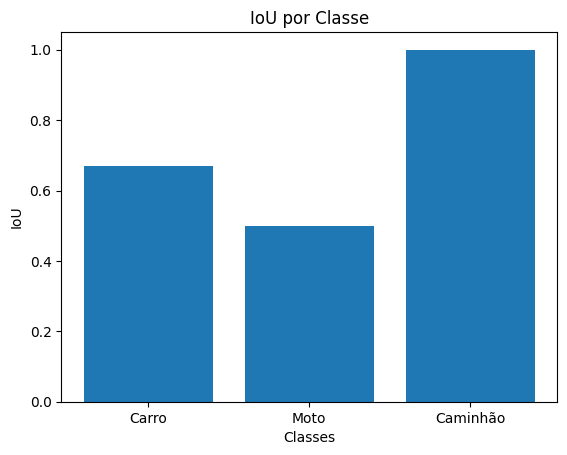

In [3]:
import matplotlib.pyplot as plt

def plot_iou_map(iou_scores, class_labels):
    plt.bar(class_labels, iou_scores)
    plt.xlabel('Classes')
    plt.ylabel('IoU')
    plt.title('IoU por Classe')
    plt.show()

# Exemplo de uso
iou_scores = [0.67, 0.5, 1]  # Valores de IoU para cada classe
class_labels = ['Carro', 'Moto', 'Caminhão']
plot_iou_map(iou_scores, class_labels)


# Parte 14: Desafios e tendências atuais em detecção de objetos

**Desafios:**
* Variabilidade em escala e ângulo;
* Oclusões e sobreposições;
* Condições de iluminação;
* Objetos pequenos e distantes;
* Diversidade intra-classe e similaridade inter-classe;
* Eficiência computacional;
* Anotações e dados de treinamento.

**Tendências:**
* Modelos leves para detecção em tempo real;
* Detecção baseada em transformers;
* AutoML e aprendizado semissupervisionado;
* Técnicas de aumento de dados (Data Augmentation);
* Aplicação de redes neurais convolucionais profundas (CNNs) híbridas;
* Uso de keypoints e landmarks;
* Técnicas de multimodalidade;
* Aplicação em áreas emergentes.

# Referências
Esse colab foi adaptado com base nesse [notebook](https://www.kaggle.com/code/muhammadfaizan65/vehicledetection-yolov8), disponível no Kaggle.